## 신용분석 모델링

#### 목적
재무데이터, 기업 리뷰 포털의 별점 데이터(기업 내부 정성 데이터 대체), 그리고 경제 지표를 활용하여 기업의 신용등급을 예측하는 모델 개발

#### 데이터 셋의 특징

- 타겟 데이터: 다중 클래스
  
- 구조: 언밸런스 구조 
  
- 타겟데이터 갯수: 800여 개 (많지 않음..)

이러한 데이터 특징으로 인해, 로지스틱 회귀 분석과 오버샘플링 방식이 학습 효과가 좋다는 점이 여러 논문에서 검증되어서 쓰기로 정함 

#### 모델 선택 : 기본적으로 로지스틱 회귀 분석을 활용하되, 아래의 모델들과의 비교를 통해 최적의 모델을 선정하려 했음 

<u>랜덤포레스트</u>

-  디시전 트리의 분산을 줄이는 배깅 기법을 기반으로 함 

<u>LightGBM</u>

- 약한 학습기를 여러 개 활용하여 예측 오차를 줄이는 부스팅 기법을 기반으로 함

<u>선형 회귀 기반 모델</u>

- 설명 변수 중 대부분이 연속형 변수이므로, 데이터의 선형 관계를 고려한 모델도 함께 비교를 위해 선택

In [1]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import pymysql

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.exceptions import ConvergenceWarning

import lightgbm as lgb

warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
cnx = pymysql.connect(
    user="multi",
    password="*****!",
    host="ec2-15-152-211-160.ap-northeast-3.compute.amazonaws.com",
    database="Data_Mart",
)

query = "SELECT * FROM model_a_processed;"
model_a = pd.read_sql(query, cnx) 

query = "SELECT * FROM model_b_processed;"
model_b = pd.read_sql(query, cnx) 

cnx.close()

/var/folders/_r/qrlg6jnd1l5b_xdkq486q0zr0000gn/T/ipykernel_17769/714872662.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  model_a = pd.read_sql(query, cnx)
/var/folders/_r/qrlg6jnd1l5b_xdkq486q0zr0000gn/T/ipykernel_17769/714872662.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  model_b = pd.read_sql(query, cnx)


#### 모델 A 
- 신용분석에 있어 주로 사용되는 지표들, 각 회계년도 사이의 경제지표들, 기업 임직원 별점데이터
- 모델 A (rank값 있음) shape: 825, 52 
- 모델 A (rank값 없음) shape: 2230, 51 

#### 모델 B
- 모델 A네 투자분석에 사용되는 지표들을 추가한 것 
- 모델 B (rank값 있음) shape: 813, 79
- 모델 B (rank값 없음) shape: 2189, 78 


In [3]:
model_a_with_y = model_a[model_a['rank'].notna()].reset_index(drop=True).drop(['corp', 'stock_code', 'sector', 'year'], axis=1)
model_a_without_y = model_a[model_a['rank'].isna()].reset_index(drop=True).drop(['corp', 'stock_code', 'sector', 'year', 'rank'], axis=1)

model_b_with_y = model_b[model_b['rank'].notna()].reset_index(drop=True).drop(['corp', 'stock_code', 'sector', 'year'], axis=1)
model_b_without_y = model_b[model_b['rank'].isna()].reset_index(drop=True).drop(['corp', 'stock_code', 'sector', 'year', 'rank'], axis=1)

model_b_with_y['rank'].unique()

array(['BBB', 'AA-', 'AA', 'A', 'A-', 'A+', 'JB', 'AA+', 'AAA'],
      dtype=object)

In [5]:
def perform_grid_search(estimator, param_grid, X_train, y_train):
    grid_search = GridSearchCV(estimator=estimator, param_grid=param_grid, 
                               cv=5, n_jobs=-1, verbose=0, random_state=42)
    grid_search.fit(X_train, y_train)
    return grid_search.best_params_

In [6]:
X_a = model_a_with_y.drop('rank', axis=1)
y_a = model_a_with_y['rank']
X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(X_a, y_a, test_size=0.2, random_state=42)

X_b = model_b_with_y.drop('rank', axis=1)
y_b = model_b_with_y['rank']
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_b, y_b, test_size=0.2, random_state=42)

In [7]:
from sklearn.preprocessing import StandardScaler

scaler_a = StandardScaler()
scaler_b = StandardScaler()

X_train_a_scaled = scaler_a.fit_transform(X_train_a)
X_train_b_scaled = scaler_b.fit_transform(X_train_b)

X_test_a_scaled = scaler_a.transform(X_test_a)
X_test_b_scaled = scaler_b.transform(X_test_b)

## Grid Search

### LogisticRegression

In [ ]:
log_reg_param_grid = {
    'C': [8, 9, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}
log_reg = LogisticRegression()

log_reg_best_params_a = perform_grid_search(log_reg, log_reg_param_grid, X_train_a_scaled, y_train_a)
log_reg_best_params_a
# {'C': 9, 'penalty': 'l2', 'solver': 'newton-cg'}

In [ ]:
log_reg_param_grid = {
    'C': [9, 10, 11, 12],
    'penalty': ['l1', 'l2'],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}
log_reg = LogisticRegression()

log_reg_best_params_b = perform_grid_search(log_reg, log_reg_param_grid, X_train_b_scaled, y_train_b)
log_reg_best_params_b
# {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}

### DecisionTreeClassifier

In [ ]:
dt_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [450, 500, 550],
    'min_samples_leaf': [1, 2],
    'min_samples_split': [1, 2, 3, 4]
}
dt = DecisionTreeClassifier()

dt_best_params_a = perform_grid_search(dt, dt_param_grid, X_train_a, y_train_a)
dt_best_params_a
# {'criterion': 'entropy', 'max_depth': 500, 'min_samples_leaf': 1, 'min_samples_split': 3}

In [ ]:
dt_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [300, 350, 400, 450],
    'min_samples_leaf': [1, 2], 
    'min_samples_split': [2, 3, 4, 5, 6]
}
dt = DecisionTreeClassifier()

dt_best_params_b = perform_grid_search(dt, dt_param_grid, X_train_b, y_train_b)
dt_best_params_b
# {'criterion': 'entropy', 'max_depth': 400, 'min_samples_leaf': 1, 'min_samples_split': 3}

### RandomForestClassifier

In [ ]:
rf_param_grid = {
    'n_estimators': [200, 300, 400, 500, 600],
    'max_features': ['log2', 'sqrt'],
    'max_depth': [17, 18, 19, 20, 21],
    'criterion': ['entropy', 'gini']
}
rf = RandomForestClassifier()

rf_best_params_a = perform_grid_search(rf, rf_param_grid, X_train_a, y_train_a)
rf_best_params_a
# {'criterion': 'entropy', 'max_depth': 18, 'max_features': 'sqrt', 'n_estimators': 500}

In [ ]:
rf_param_grid = {
    'n_estimators': [700, 800, 900],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [11, 12, 13, 14, 15],
    'criterion': ['gini', 'entropy']
}
rf = RandomForestClassifier()

rf_best_params_b = perform_grid_search(rf, rf_param_grid, X_train_b, y_train_b)
rf_best_params_b
# {'criterion': 'gini', 'max_depth': 13, 'max_features': 'sqrt', 'n_estimators': 800}

### SVC

In [ ]:
svc_param_grid = {
    'C': [25, 30, 35, 40],
    'gamma': ['scale', 'auto', 0.1, 1, 10],
    'kernel': ['linear', 'rbf']
}
svc = SVC()

svc_best_params_a = perform_grid_search(svc, svc_param_grid, X_train_a_scaled, y_train_a)
svc_best_params_a
# {'C': 35, 'gamma': 'auto', 'kernel': 'rbf'}

In [ ]:
svc_param_grid = {
    'C': [55, 60, 65, 70],
    'gamma': ['scale', 'auto', 0.1, 1, 10],
    'kernel': ['linear', 'rbf']
}
svc = SVC()

svc_best_params_b = perform_grid_search(svc, svc_param_grid, X_train_b_scaled, y_train_b)
svc_best_params_b
# {'C': 60, 'gamma': 'auto', 'kernel': 'rbf'}

### LightGBM

In [ ]:
lgbm_param_grid = {
    'n_estimators': [250, 300, 350],
    'learning_rate': [0.001, 0.01, 0.02, 0.03, 0.04],
    'max_depth': [10, 12, 14],
    'boosting_type': ['gbdt'],  
    'objective': ['multiclass'],
    'num_class': [len(y_train_a.unique())], 
}

lgbm = lgb.LGBMClassifier()

lgbm_best_params_a = perform_grid_search(lgbm, lgbm_param_grid, X_train_a, y_train_a)
lgbm_best_params_a
# {'boosting_type': 'gbdt', 'learning_rate': 0.03, 'max_depth': 12, 'n_estimators': 300, 'num_class': 9, 'objective': 'multiclass'}

In [ ]:
lgbm_param_grid = {
    'n_estimators': [350, 400, 450, 500],
    'learning_rate': [0.02, 0.03, 0.04],
    'max_depth': [6, 8, 10],
    'boosting_type': ['gbdt'],  
    'objective': ['multiclass'],
    'num_class': [len(y_train_b.unique())], 
}

lgbm = lgb.LGBMClassifier()

lgbm_best_params_b = perform_grid_search(lgbm, lgbm_param_grid, X_train_b, y_train_b)
lgbm_best_params_b
# {'boosting_type': 'gbdt', 'learning_rate': 0.03, 'max_depth': 8, 'n_estimators': 400, 'num_class': 9, 'objective': 'multiclass'}

### Model

### LogisticRegression

log_reg_best_params

{'C': 9, 'penalty': 'l2', 'solver': 'newton-cg'}

{'C': 9, 'penalty': 'l1', 'solver': 'liblinear'}

In [48]:
log_reg = LogisticRegression(C=9, penalty='l2', solver='newton-cg', random_state=42)
log_reg.fit(X_train_a_scaled, y_train_a)

y_pred = log_reg.predict(X_test_a_scaled)
print("Logistic Regression Classification Report for Model A:")
print(classification_report(y_test_a, y_pred))

Logistic Regression Classification Report for Model A:
              precision    recall  f1-score   support

           A       0.35      0.28      0.31        25
          A+       0.52      0.44      0.48        25
          A-       0.69      0.52      0.59        21
          AA       0.65      0.62      0.63        21
         AA+       0.67      1.00      0.80         6
         AA-       0.45      0.52      0.48        29
         AAA       1.00      0.80      0.89         5
         BBB       0.39      0.54      0.45        13
          JB       0.71      0.85      0.77        20

    accuracy                           0.55       165
   macro avg       0.60      0.62      0.60       165
weighted avg       0.55      0.55      0.55       165



In [14]:
log_reg = LogisticRegression(C=9, penalty='l1', solver='liblinear', random_state=42)
log_reg.fit(X_train_b_scaled, y_train_b)

y_pred = log_reg.predict(X_test_b_scaled)
print("Logistic Regression Classification Report for Model B:")
print(classification_report(y_test_b, y_pred))

Logistic Regression Classification Report for Model B:
              precision    recall  f1-score   support

           A       0.43      0.28      0.34        32
          A+       0.22      0.23      0.22        22
          A-       0.41      0.41      0.41        17
          AA       0.65      0.57      0.60        23
         AA+       0.67      0.86      0.75         7
         AA-       0.48      0.54      0.51        26
         AAA       1.00      0.50      0.67         4
         BBB       0.25      0.50      0.33        10
          JB       0.77      0.77      0.77        22

    accuracy                           0.48       163
   macro avg       0.54      0.52      0.51       163
weighted avg       0.50      0.48      0.48       163



### DecisionTreeClassifier

dt_best_params

{'criterion': 'entropy', 'max_depth': 500, 'min_samples_leaf': 1, 'min_samples_split': 3}

{'criterion': 'entropy', 'max_depth': 400, 'min_samples_leaf': 1, 'min_samples_split': 3}

In [15]:
dt = DecisionTreeClassifier(criterion='entropy', max_depth=500, min_samples_leaf=1, min_samples_split=3, random_state=42)
dt.fit(X_train_a, y_train_a)

y_pred = dt.predict(X_test_a)
print("Decision Tree Classification Report for Model A:")
print(classification_report(y_test_a, y_pred))

Decision Tree Classification Report for Model A:
              precision    recall  f1-score   support

           A       0.58      0.56      0.57        25
          A+       0.40      0.40      0.40        25
          A-       0.67      0.76      0.71        21
          AA       0.72      0.86      0.78        21
         AA+       0.67      1.00      0.80         6
         AA-       0.73      0.55      0.63        29
         AAA       0.67      0.40      0.50         5
         BBB       0.60      0.69      0.64        13
          JB       1.00      0.90      0.95        20

    accuracy                           0.66       165
   macro avg       0.67      0.68      0.66       165
weighted avg       0.67      0.66      0.66       165



In [16]:
dt = DecisionTreeClassifier(criterion='entropy', max_depth=400, min_samples_leaf=1, min_samples_split=3, random_state=42)
dt.fit(X_train_b, y_train_b)

y_pred = dt.predict(X_test_b)
print("Decision Tree Classification Report for Model B:")
print(classification_report(y_test_b, y_pred))

Decision Tree Classification Report for Model B:
              precision    recall  f1-score   support

           A       0.59      0.59      0.59        32
          A+       0.44      0.64      0.52        22
          A-       0.55      0.65      0.59        17
          AA       0.83      0.65      0.73        23
         AA+       1.00      0.86      0.92         7
         AA-       0.67      0.62      0.64        26
         AAA       1.00      0.75      0.86         4
         BBB       0.78      0.70      0.74        10
          JB       1.00      0.86      0.93        22

    accuracy                           0.67       163
   macro avg       0.76      0.70      0.72       163
weighted avg       0.71      0.67      0.68       163



### RandomForestClassifier

rf_best_params

{'criterion': 'entropy', 'max_depth': 18, 'max_features': 'sqrt', 'n_estimators': 500}

{'criterion': 'gini', 'max_depth': 13, 'max_features': 'sqrt', 'n_estimators': 800}

In [11]:
clf = RandomForestClassifier(criterion='entropy', max_depth=18, max_features='sqrt',
                             n_estimators=500, random_state=42)
clf.fit(X_train_a, y_train_a)

y_pred = clf.predict(X_test_a)
print("Random Forest Classification Report for Model A:")
print(classification_report(y_test_a, y_pred))

Random Forest Classification Report for Model A:
              precision    recall  f1-score   support

           A       0.78      0.84      0.81        25
          A+       0.84      0.64      0.73        25
          A-       1.00      0.81      0.89        21
          AA       0.83      0.90      0.86        21
         AA+       1.00      1.00      1.00         6
         AA-       0.71      0.86      0.78        29
         AAA       1.00      1.00      1.00         5
         BBB       0.79      0.85      0.81        13
          JB       1.00      0.95      0.97        20

    accuracy                           0.84       165
   macro avg       0.88      0.87      0.87       165
weighted avg       0.85      0.84      0.84       165



In [12]:
clf = RandomForestClassifier(criterion='gini', max_depth=13, max_features='sqrt',
                             n_estimators=800, random_state=42)
clf.fit(X_train_b, y_train_b)

y_pred = clf.predict(X_test_b)
print("Random Forest Classification Report for Model B:")
print(classification_report(y_test_b, y_pred))

Random Forest Classification Report for Model B:
              precision    recall  f1-score   support

           A       0.73      0.69      0.71        32
          A+       0.61      0.77      0.68        22
          A-       0.89      0.47      0.62        17
          AA       0.91      0.87      0.89        23
         AA+       1.00      0.86      0.92         7
         AA-       0.76      0.85      0.80        26
         AAA       1.00      1.00      1.00         4
         BBB       0.64      0.90      0.75        10
          JB       1.00      0.95      0.98        22

    accuracy                           0.79       163
   macro avg       0.84      0.82      0.82       163
weighted avg       0.81      0.79      0.79       163



### SVC

svc_best_params

{'C': 35, 'gamma': 'auto', 'kernel': 'rbf'}

{'C': 60, 'gamma': 'auto', 'kernel': 'rbf'}

In [17]:
svc = SVC(C=35, gamma='auto', kernel='rbf', random_state=42)
svc.fit(X_train_a_scaled, y_train_a)

y_pred = svc.predict(X_test_a_scaled)
print("SVC Classification Report for Model A:")
print(classification_report(y_test_a, y_pred))

SVC Classification Report for Model A:
              precision    recall  f1-score   support

           A       0.50      0.56      0.53        25
          A+       0.45      0.52      0.48        25
          A-       0.73      0.38      0.50        21
          AA       0.55      0.57      0.56        21
         AA+       0.62      0.83      0.71         6
         AA-       0.59      0.69      0.63        29
         AAA       1.00      0.80      0.89         5
         BBB       0.64      0.54      0.58        13
          JB       0.89      0.80      0.84        20

    accuracy                           0.60       165
   macro avg       0.66      0.63      0.64       165
weighted avg       0.62      0.60      0.60       165



In [18]:
svc = SVC(C=60, gamma='auto', kernel='rbf', random_state=42)
svc.fit(X_train_b_scaled, y_train_b)

y_pred = svc.predict(X_test_b_scaled)
print("SVC Classification Report for Model B:")
print(classification_report(y_test_b, y_pred))

SVC Classification Report for Model B:
              precision    recall  f1-score   support

           A       0.57      0.62      0.60        32
          A+       0.46      0.59      0.52        22
          A-       0.62      0.29      0.40        17
          AA       0.80      0.70      0.74        23
         AA+       0.86      0.86      0.86         7
         AA-       0.62      0.69      0.65        26
         AAA       1.00      0.50      0.67         4
         BBB       0.56      0.50      0.53        10
          JB       0.76      0.86      0.81        22

    accuracy                           0.64       163
   macro avg       0.69      0.62      0.64       163
weighted avg       0.65      0.64      0.63       163



### LightGBM

lgbm_best_params

{'boosting_type': 'gbdt', 'learning_rate': 0.03, 'max_depth': 12, 'n_estimators': 300, 'num_class': 9, 'objective': 'multiclass'}

{'boosting_type': 'gbdt', 'learning_rate': 0.03, 'max_depth': 8, 'n_estimators': 400, 'num_class': 9, 'objective': 'multiclass'}


In [19]:
lgbm = lgb.LGBMClassifier(boosting_type='gbdt', learning_rate=0.03, max_depth=12, n_estimators=300, num_class=9, objective='multiclass', random_state=42)
lgbm.fit(X_train_a, y_train_a)

y_pred = lgbm.predict(X_test_a)
print("LightGBM Classification Report for Model A:")
print(classification_report(y_test_a, y_pred))

LightGBM Classification Report for Model A:
              precision    recall  f1-score   support

           A       0.73      0.76      0.75        25
          A+       0.86      0.76      0.81        25
          A-       0.82      0.86      0.84        21
          AA       0.95      0.90      0.93        21
         AA+       0.86      1.00      0.92         6
         AA-       0.79      0.90      0.84        29
         AAA       1.00      1.00      1.00         5
         BBB       1.00      0.85      0.92        13
          JB       1.00      0.95      0.97        20

    accuracy                           0.86       165
   macro avg       0.89      0.89      0.89       165
weighted avg       0.87      0.86      0.86       165



In [20]:
lgbm = lgb.LGBMClassifier(boosting_type='gbdt', learning_rate=0.03, max_depth=8, n_estimators=400, num_class=9, objective='multiclass', random_state=42)
lgbm.fit(X_train_b, y_train_b)

y_pred = lgbm.predict(X_test_b)
print("LightGBM Classification Report for Model B:")
print(classification_report(y_test_b, y_pred))

LightGBM Classification Report for Model B:
              precision    recall  f1-score   support

           A       0.79      0.72      0.75        32
          A+       0.66      0.86      0.75        22
          A-       0.87      0.76      0.81        17
          AA       0.95      0.83      0.88        23
         AA+       0.86      0.86      0.86         7
         AA-       0.89      0.92      0.91        26
         AAA       1.00      1.00      1.00         4
         BBB       0.73      0.80      0.76        10
          JB       1.00      0.95      0.98        22

    accuracy                           0.84       163
   macro avg       0.86      0.86      0.86       163
weighted avg       0.85      0.84      0.84       163



### Oversampling using SMOTE
- 전반적으로 결과가 좋아지지 않음

In [21]:
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import lightgbm as lgb

# Oversampling with SMOTE
smote = SMOTE(random_state=42)
X_train_a_resampled, y_train_a_resampled = smote.fit_resample(X_train_a, y_train_a)

X_train_a_scaled_resampled, y_train_a_scaled_resampled = smote.fit_resample(X_train_a_scaled, y_train_a)

# RandomForest
clf = RandomForestClassifier(criterion='entropy', max_depth=18, max_features='sqrt',
                             n_estimators=500, random_state=42)
clf.fit(X_train_a_resampled, y_train_a_resampled)
y_pred = clf.predict(X_test_a)
print("Random Forest Classification Report for Model A after SMOTE:")
print(classification_report(y_test_a, y_pred))

# Logistic Regression
log_reg = LogisticRegression(C=9, penalty='l2', solver='newton-cg', random_state=42)
log_reg.fit(X_train_a_scaled_resampled, y_train_a_scaled_resampled)
y_pred = log_reg.predict(X_test_a_scaled)
print("Logistic Regression Classification Report for Model A after SMOTE:")
print(classification_report(y_test_a, y_pred))

# Decision Tree
dt = DecisionTreeClassifier(criterion='entropy', max_depth=500, min_samples_leaf=1, min_samples_split=3, random_state=42)
dt.fit(X_train_a_resampled, y_train_a_resampled)
y_pred = dt.predict(X_test_a)
print("Decision Tree Classification Report for Model A after SMOTE:")
print(classification_report(y_test_a, y_pred))

# SVC
svc = SVC(C=35, gamma='auto', kernel='rbf', random_state=42)
svc.fit(X_train_a_scaled_resampled, y_train_a_scaled_resampled)
y_pred = svc.predict(X_test_a_scaled)
print("SVC Classification Report for Model A after SMOTE:")
print(classification_report(y_test_a, y_pred))

# LightGBM
lgbm = lgb.LGBMClassifier(boosting_type='gbdt', learning_rate=0.03, max_depth=12, n_estimators=300, num_class=9, objective='multiclass', random_state=42)
lgbm.fit(X_train_a_resampled, y_train_a_resampled)
y_pred = lgbm.predict(X_test_a)
print("LightGBM Classification Report for Model A after SMOTE:")
print(classification_report(y_test_a, y_pred))

Random Forest Classification Report for Model A after SMOTE:
              precision    recall  f1-score   support

           A       0.80      0.80      0.80        25
          A+       0.85      0.68      0.76        25
          A-       0.83      0.90      0.86        21
          AA       0.86      0.86      0.86        21
         AA+       0.75      1.00      0.86         6
         AA-       0.78      0.86      0.82        29
         AAA       1.00      1.00      1.00         5
         BBB       1.00      0.92      0.96        13
          JB       1.00      0.95      0.97        20

    accuracy                           0.85       165
   macro avg       0.87      0.89      0.88       165
weighted avg       0.86      0.85      0.85       165

Logistic Regression Classification Report for Model A after SMOTE:
              precision    recall  f1-score   support

           A       0.38      0.20      0.26        25
          A+       0.55      0.44      0.49        25
    

### Feature Importance: LightGBM & RandomForestClassifier 

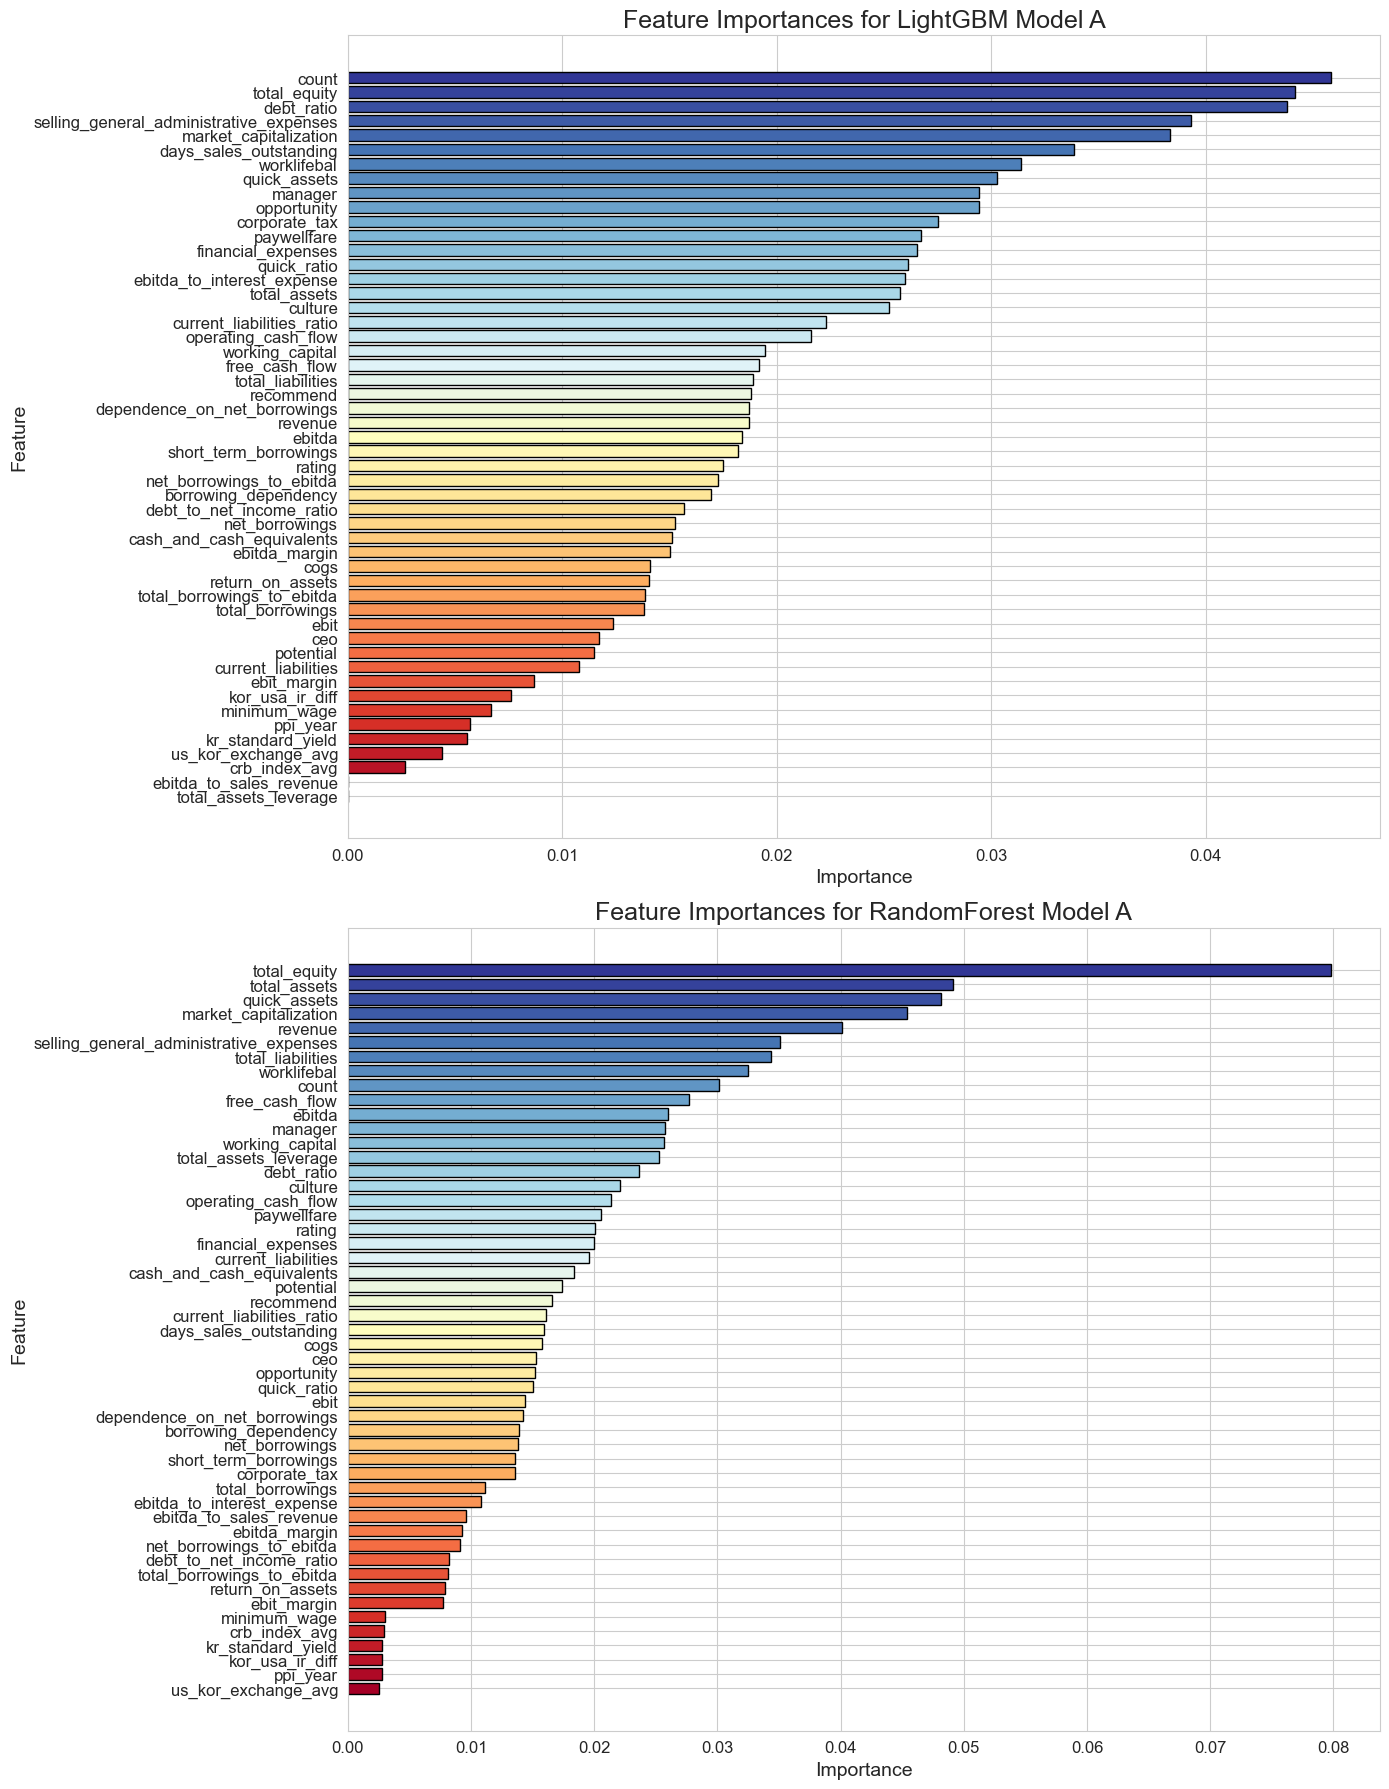

In [24]:
feature_importances_lgbm = lgbm.feature_importances_
feature_importances_lgbm_normalized = feature_importances_lgbm / feature_importances_lgbm.sum()
sorted_indices_lgbm = np.argsort(feature_importances_lgbm_normalized)[::-1]
sorted_features_lgbm = [(X_train_a.columns[i], feature_importances_lgbm_normalized[i]) for i in sorted_indices_lgbm]

feature_importances_rf = clf.feature_importances_
sorted_indices_rf = np.argsort(feature_importances_rf)[::-1]
sorted_features_rf = [(X_train_a.columns[i], feature_importances_rf[i]) for i in sorted_indices_rf]

sns.set_style("whitegrid")
colors_lgbm = cm.RdYlBu_r(np.linspace(0, 1, len(sorted_features_lgbm)))
colors_rf = cm.RdYlBu_r(np.linspace(0, 1, len(sorted_features_rf)))

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(14, 18))

# LightGBM Plot 
axs[0].barh([feature[0] for feature in sorted_features_lgbm], 
           [feature[1] for feature in sorted_features_lgbm],
           align='center', color=colors_lgbm, edgecolor='black')
axs[0].set_title('Feature Importances for LightGBM Model A', fontsize=18)
axs[0].invert_yaxis()  
axs[0].set_xlabel('Importance', fontsize=14)
axs[0].set_ylabel('Feature', fontsize=14)
axs[0].tick_params(axis='both', labelsize=12)

# RandomForest Plot 
axs[1].barh([feature[0] for feature in sorted_features_rf], 
           [feature[1] for feature in sorted_features_rf], 
           align='center', color=colors_rf, edgecolor='black')
axs[1].set_title('Feature Importances for RandomForest Model A', fontsize=18)
axs[1].invert_yaxis()  
axs[1].set_xlabel('Importance', fontsize=14)
axs[1].set_ylabel('Feature', fontsize=14)
axs[1].tick_params(axis='both', labelsize=12)

plt.tight_layout()
plt.show()

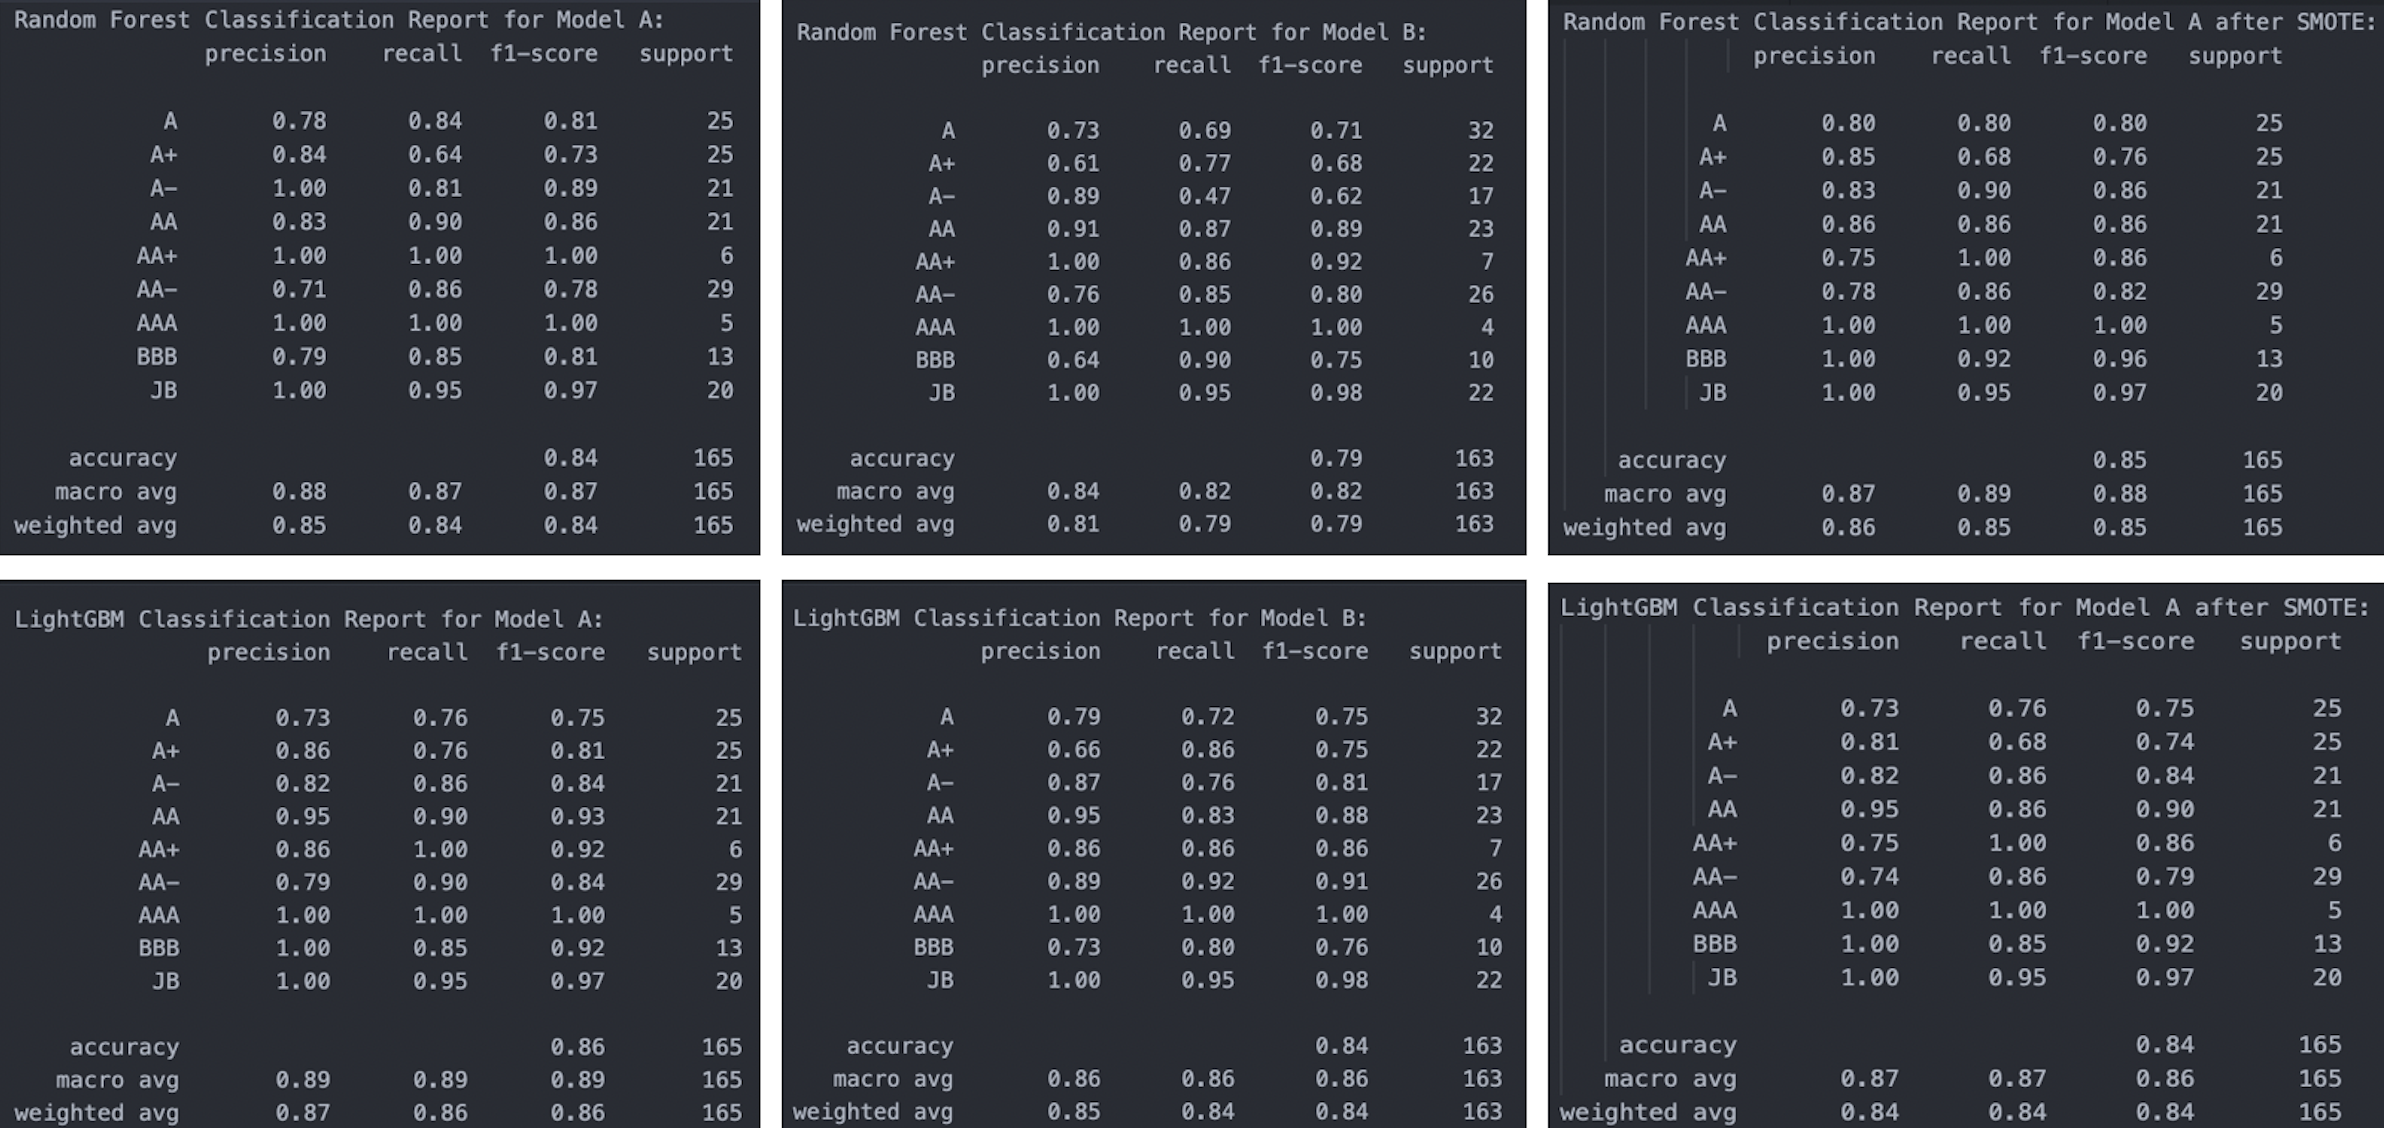

### 모델 선정 

후보 리스트: 
1. Random Forest Classification 모델 A 
2. Random Forest Classification 모델 B 
3. Random Forest Classification 모델 A, SMOTE 사용 
4. LightGBM Classification 모델 A
5. LightGBM Classification 모델 B 
6. LightGBM Classification 모델 A, SMOTE 사용

일반적으로 모델 A, B를 비교해 보았을 때 모델 A에 투자지표를 설명변수로 추가하여 모델 개선을 시도하였으나 오히려 예측성능이 저하. 
따라서 신용평가사와 일반적인 신용분석에서 사용되는 지표들이 예상대로 신용등급 예측에 더 효과적인 변수로 작용함

스모트 기법을 활용해여 타겟 데이터가 언밸런스한 문제를 보완한 후 모델 학습을 진행하였으나, 비율이 적은 데이터 근처에 무작위로 데이터를 형성하여 데이터 셋의 변형을 가하는 이점에 비해 학습 성능의 큰 차이가 없음.
따라서 스모트 기법을 활용하기 보다 있는 원래 데이터셋을 그대로 이용하기로 결정

RandomForest VS LightGBM 

LightGBM의 성능이 더 좋지만...
- 랜덤포레스트 모델링 결과가 재무 데이터와 경제 지표를 더 골고루 설명하고 신용등급 예측의 일반적인 이론에 더 적합함 -> 해당 모델이 일반적인 신용평가 이론과 원칙을 잘 반영하여 주로 금융업계에 종사하는 예상고객층에 더 쉽게 설명할 수 있고 신뢰성을 줄 수 있음 
- 기업점수 데이터의 갯수를 의미하는 컬럼을 가장 중요한 설명변수로 채택한 라이트지비엠 모델의 경우 새로운 기업이나 리뷰데이터가 부족하나 재무 상태가 양호안 기업의 신용등급을 예측할 때 잘못 예측할 가능성이 높음 

위에 설명과 성능 차이가 그렇게 크지 않은 걸 고려해서 신용지표와 경제지표, 별점데이터를 학습데이터로 활용한 랜덤포레스트 모델을 최종 모델로 선택함 

1. Random Forest Classification 모델 A 

<b> clf = RandomForestClassifier(criterion='entropy', max_depth=18, max_features='sqrt', n_estimators=500, random_state=42) </b>



### 기존 신용평점 지표 vs 기존 신용평점 지표 + 경제데이터 vs 기존 신용평점 지표 + 별점데이터 vs 기존 신용평점 지표 + 별점데이터 + 경제데이터

In [32]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

model_a_with_y = model_a[model_a['rank'].notna()].reset_index(drop=True).drop(['corp', 'stock_code', 'sector', 'year'], axis=1)
model_a_without_y = model_a[model_a['rank'].isna()].reset_index(drop=True).drop(['corp', 'stock_code', 'sector', 'year', 'rank'], axis=1)

review_columns = ['count', 'rating', 'paywellfare', 'worklifebal', 'culture', 'opportunity', 'manager', 'recommend', 'ceo', 'potential']
macro_indicators_columns = ['minimum_wage', 'us_kor_exchange_avg', 'ppi_year', 'kor_usa_ir_diff', 'kr_standard_yield', 'crb_index_avg'] 
review_macro_indicators_columns = review_columns + macro_indicators_columns 

configurations = [
    {'name': "기존 신용평점 지표만 있는 모델", 'drop_columns': ['rank'] + review_macro_indicators_columns},
    {'name': "기존 신용평점 지표 + 경제데이터 있는 모델", 'drop_columns': ['rank'] + review_columns},
    {'name': "기존 신용평점 지표 + 별점데이터 있는 모델", 'drop_columns': ['rank'] + macro_indicators_columns},
    {'name': "기존 신용평점 지표 + 별점데이터 + 경제데이터 다 있는 모델", 'drop_columns': ['rank']}
]

for config in configurations:
    X_a = model_a_with_y.drop(config['drop_columns'], axis=1)
    y_a = model_a_with_y['rank']
    X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(X_a, y_a, test_size=0.2, random_state=42)

    clf = RandomForestClassifier(criterion='entropy', max_depth=18, max_features='sqrt',
                                 n_estimators=500, random_state=42)
    clf.fit(X_train_a, y_train_a)
    y_pred = clf.predict(X_test_a)

    accuracy = accuracy_score(y_test_a, y_pred)
    weighted_precision, weighted_recall, weighted_f1, _ = precision_recall_fscore_support(y_test_a, y_pred, average='weighted')
    
    print(config['name'])
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Weighted Avg - Precision: {weighted_precision:.2f}, Recall: {weighted_recall:.2f}, F1-score: {weighted_f1:.2f}")
    print("-------------------------------------------------------------")

기존 신용평점 지표만 있는 모델
Accuracy: 0.73
Weighted Avg - Precision: 0.73, Recall: 0.73, F1-score: 0.73
-------------------------------------------------------------
기존 신용평점 지표 + 경제데이터 있는 모델
Accuracy: 0.72
Weighted Avg - Precision: 0.72, Recall: 0.72, F1-score: 0.71
-------------------------------------------------------------
기존 신용평점 지표 + 별점데이터 있는 모델
Accuracy: 0.83
Weighted Avg - Precision: 0.84, Recall: 0.83, F1-score: 0.83
-------------------------------------------------------------
기존 신용평점 지표 + 별점데이터 + 경제데이터 다 있는 모델
Accuracy: 0.84
Weighted Avg - Precision: 0.85, Recall: 0.84, F1-score: 0.84
-------------------------------------------------------------


| 모델                                         | 정확도 | 정밀도 |  재현율 | F1 점수 |
|------------------------------------------------------|----------|--------------------|-----------------|-------------------|
| 기존 신용평점 지표만 있는 모델                          | 0.73     | 0.73               | 0.73            | 0.73              |
| 기존 신용평점 지표 + 경제데이터 있는 모델               | 0.72     | 0.72               | 0.72            | 0.71              |
| 기존 신용평점 지표 + 별점데이터 있는 모델               | 0.83     | 0.84               | 0.83            | 0.83              |
| 기존 신용평점 지표 + 별점데이터 + 경제데이터 다 있는 모델 | 0.84     | 0.85               | 0.84            | 0.84              |

<u>모델 성능 분석</u> 

경제 데이터 추가: 경제 데이터만 추가하였을 때, 기존 모델 대비 성능 향상이 없음 

별점 데이터 추가: 별점 데이터를 추가하였을 때, 정확도, 재현율, F1 점수 모두 상당히 향상됨 

종합 모델 (경제 + 별점 데이터 도입): 모든 데이터를 포함한 종합 모델은 가장 뛰어난 성능을 보임<br>
따라서, 최종 모델로 경제 데이터와 별점 데이터를 모두 포함한 종합 모델을 선택함 

### 선정한 모델 사용해서 신용등급 없는 데이터 예측

In [25]:
clf = RandomForestClassifier(criterion='entropy', max_depth=18, max_features='sqrt',
                             n_estimators=500, random_state=42)
clf.fit(X_train_a, y_train_a)

predicted_ranks = clf.predict(model_a_without_y)

model_a_without_y['predicted_rank'] = predicted_ranks

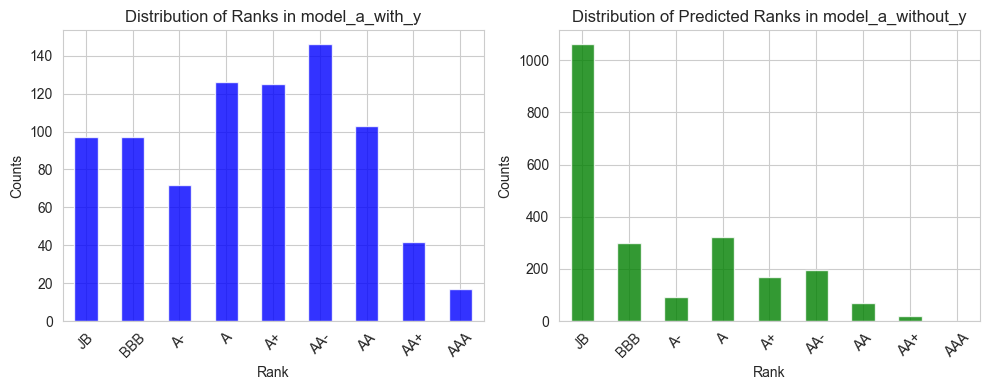

In [27]:
order = ['JB', 'BBB', 'A-', 'A', 'A+', 'AA-', 'AA', 'AA+', 'AAA']

with_y_counts = model_a_with_y['rank'].value_counts().reindex(order).fillna(0)
without_y_counts = model_a_without_y['predicted_rank'].value_counts().reindex(order).fillna(0)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

with_y_counts.plot(kind='bar', alpha=0.8, color='blue', ax=axes[0])
axes[0].set_title('Distribution of Ranks in model_a_with_y')
axes[0].set_xlabel('Rank')
axes[0].set_ylabel('Counts')
axes[0].set_xticklabels(order, rotation=45)

without_y_counts.plot(kind='bar', alpha=0.8, color='green', ax=axes[1])
axes[1].set_title('Distribution of Predicted Ranks in model_a_without_y')
axes[1].set_xlabel('Rank')
axes[1].set_ylabel('Counts')
axes[1].set_xticklabels(order, rotation=45)

plt.tight_layout()
plt.show()

### rank값 있는 기업 VS rank값 없는 기업 

#### 피쳐임포턴스에서 top 5 피쳐들 분석

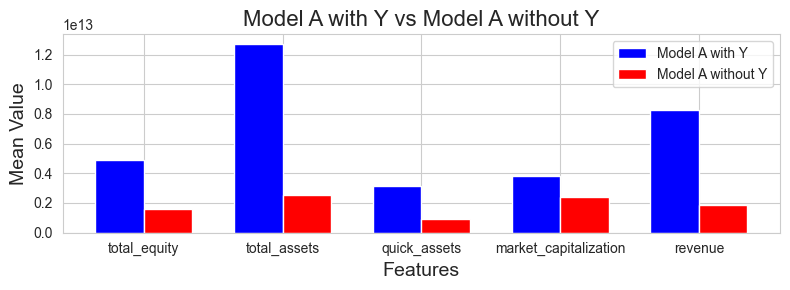

In [28]:
top_5_features = ['total_equity', 'total_assets', 'quick_assets', 'market_capitalization', 'revenue']

means_with_y = [model_a_with_y[feature].mean() for feature in top_5_features]
means_without_y = [model_a_without_y[feature].mean() for feature in top_5_features]

bar_width = 0.35
index = np.arange(len(top_5_features))

plt.figure(figsize=(8, 3))

bar1 = plt.bar(index, means_with_y, bar_width, color='blue', label='Model A with Y')
bar2 = plt.bar(index + bar_width, means_without_y, bar_width, color='red', label='Model A without Y')

plt.xlabel('Features', fontsize=14)
plt.ylabel('Mean Value', fontsize=14)
plt.title('Model A with Y vs Model A without Y', fontsize=16)
plt.xticks(index + bar_width / 2, top_5_features) 
plt.legend()
plt.tight_layout()

plt.show()